# Diseño de una red clasificación y uso de transferencia de aprendizaje

## CNN para la clasificación de medios de transporte

Se presenta una arquitectura de red neuronal híbrida, que cuenta con capas de red convolucionales desde la entrada hasta cierta capa oculta y se conectan con capas Fully Connected en las últimas capas ocultas, junto con la capa de salida para realizar una clasificación de diferentes medios de transporte.

#### Cargue de librerías

In [1]:
import torch
import numpy as np 
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from collections import OrderedDict

c:\Users\GIIEE\Documents\johan\conda\envs\TORCH\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lectura de GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA disponible. Entrenamiento en GPU.')
else:
    print('CUDA no disponible. Entrenamiento en CPU.')

CUDA disponible. Entrenamiento en GPU.


#### Definicón del directorio de las imágenes a utilizar y cargue de las misma

En esta sección se realiza la configuración para aplicar DataAugmentatios al set de datos elegido. Como transformaciones a aplicar, se eligieron: 

* Datos de entrenamiento: Dar la vuelta a la foto de forma aleatoria horizontalmente (RandomHorizontalFlip).
* Datos de validación: Hacer una rotación de 10° aleatoriamente (transforms.RandomRotation(10)). 

También realizó una normalización con algunos valores por defecto para expereminetos de media, desviación estandar de 0.5 y 0.5 respectivamente, para cada una de las capas RGB de las imágenes. En el mismo sentido, al ser requerido, se realiza un transformación a tensor de cada imagen.

Respecto al set de datos, este es un conjunto de datos de muy alta calidad de aviones y carros. Todas las imágenes son varían en su tamaño, en formato jpg. Por lo anterior, se aplica un resize fijo de 224, 224 para todas las imágenes.

In [3]:
# Ruta de las imágenes:
data_dir_train = "C:/Users/GIIEE/Documents/johan/Maestria/DL/Taller 2/DataSet/plane_vs_cars/train"
data_dir_val = "C:/Users/GIIEE/Documents/johan/Maestria/DL/Taller 2/DataSet/plane_vs_cars/val"
data_dir_test = "C:/Users/GIIEE/Documents/johan/Maestria/DL/Taller 2/DataSet/plane_vs_cars/test"


# Tamaño de los batches:
batch_size = 16

# Definición de las trannsformaciones a aplicar al set de datos:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.RandomRotation(10),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Se leen las imágenes:
data_train = datasets.ImageFolder(data_dir_train, transform = transform_train)
data_val = datasets.ImageFolder(data_dir_val, transform = transform_val)
data_test = datasets.ImageFolder(data_dir_test, transform = transform_test)

num_train = len(data_train)
num_val = len(data_val)
num_test = len(data_test)
print(f'Cantidad de imágenes de entrenamiento: {num_train}')
print(f'Cantidad de imágenes de validación: {num_val}')
print(f'Cantidad de imágenes de prueba: {num_test}')

indices_train = list(range(num_train))
np.random.shuffle(indices_train)
indices_val = list(range(num_val))
np.random.shuffle(indices_val)
indices_test = list(range(num_test))
np.random.shuffle(indices_test)

train_sampler = SubsetRandomSampler(indices_train)
valid_sampler = SubsetRandomSampler(indices_val)
test_sampler = SubsetRandomSampler(indices_test)

# Cargue de los Dataloader correspondientes:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(data_val, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(data_test, batch_size = num_test, shuffle = True) # El grupo de prueba no se divide en batches.

# Etiquetas de los grupos a clasificar:
classes = ['cars', 'planes']

Cantidad de imágenes de entrenamiento: 1017
Cantidad de imágenes de validación: 339
Cantidad de imágenes de prueba: 339


#### Visualización de la variación de la funciones de pérdida para los datos de entrenamiento y validación y del Accuraccy durante el entrenamiento.

#### Visualización de algunas imágenes

Se muestran las imagenes correspondientes a un batch del set de validación. Se evidencian algunos giros aleatorios de las imágenes aplicadas en el DataAugmentation.

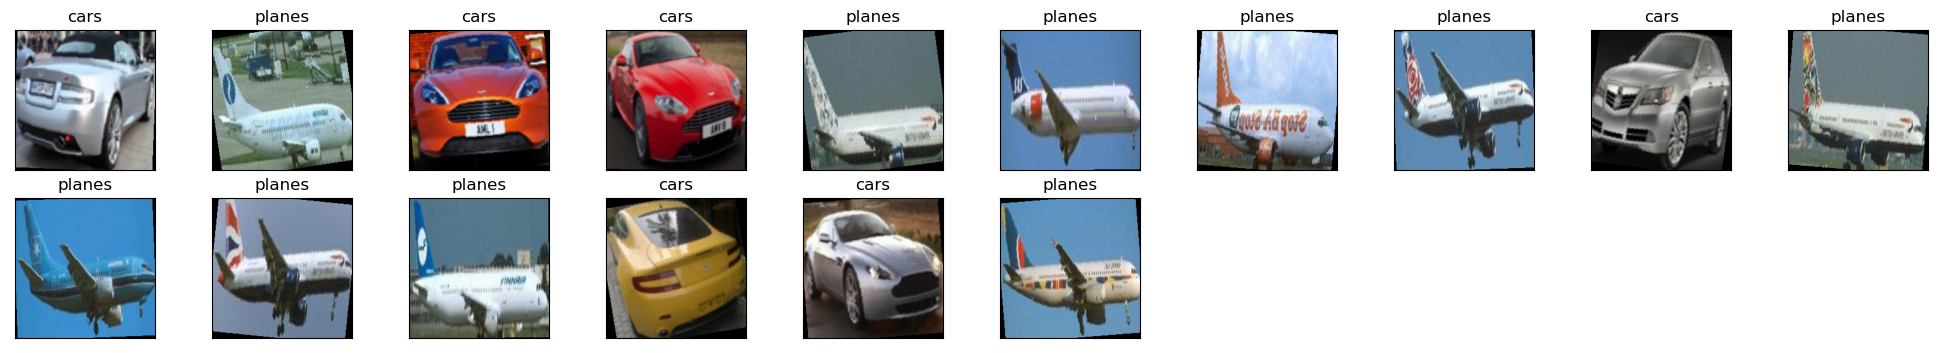

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalización.
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Se convierte de tensor a imagen

dataiter = iter(valid_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Arquitectura de la red 

Se define una arquitectura de red neuronal con 5 capas convolucionales, seguidas por capas de Max Pooling y de una arquitectura Fully Connected de 3 capas, seguida de Dropout con un porcentaje del 20 % de desactivación aleatoria de las neuronas. El resumen de la arquitectura definida se puede observar en secciones posteriores.

In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # prof, 224, 224
        self.conv_in = nn.Conv2d(3, 4, 3, padding = 1) # prof, 112, 112
        self.conv1 = nn.Conv2d(4, 8, 3, padding = 1) # prof, 56, 56
        self.conv2 = nn.Conv2d(8, 16, 3, padding = 1) # prof, 28, 28
        self.conv3 = nn.Conv2d(16, 32, 3, padding = 1) # prof, 14, 14
        self.conv4 = nn.Conv2d(32, 64, 3, padding = 1) # prof, 7, 7
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(64 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc_out = nn.Linear(256, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_in(x))) 
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

model = Net()
print(model)

# Se mueve el modelo a GPU si está disponible:
if train_on_gpu:
    model.cuda()

# Resumen de la arquitectura definida:
print('Resumen de la arquitectura definida:')
summary(model, input_size=(3, 224, 224))

Net(
  (conv_in): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Resumen de la arquitectura definida:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 224, 224]             112
         MaxPool2d-2          [-1, 4, 112, 112]               0
 

#### Definicón de la función de costo y del optimizador

Como función de costo de configura la función 'CrossEntropyLoss' y se elige el optimizador de Adam al ser uno de los más eficientes, con una tasa de aprendizaje fijada en 1e-3 ya que esta se toma como una tasa por defecto adecuada para cualquier problema.

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### Ciclo de entrenamiento

Se realiza el proceso de entrenamiento de la arquitectura definida para una cantidad de 20 épocas. Se almacena de la misma manera el cambio de la función de pérdida establecida, para determinar la calidad del entrenamiento, como se muestra en una sección más próxima.

In [7]:
# Número de épocas:
n_epochs = 20

In [8]:
# Vectores para guardar la variación de la función de pérdida:
train_graph=[]
valid_graph=[]
accuracy_graph = []

for epoch in range(1, n_epochs+1):
    if epoch == 1:
        valid_loss_min = np.Inf # Valor inicial de la función de perdida de validación.

    # Reinicio de las funciones de pérdida:
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    # Entrenamiento #
    #################

    # Modelo en modo entrenamiento:
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        num_correct = 0
        num_total = 0

        # Se mueve el modelo a GPU:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        # Cálculo de los scores:
        output = model(data)

        _, pred = output.max(dim=1) #pred shape (mb_size )
        num_correct += (pred == target.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
        num_total += pred.size(0)

        # Cálculo de la función de pérdida y actualización de parámetros:
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    accuracy_graph.append(float(num_correct)/num_total)
        
    ############## 
    # validación #
    ##############
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Media de la función de pérdida:
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_graph.append(train_loss)
    valid_graph.append(valid_loss) 
        
    # Se muestran las estadísticas:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuraccy: {:.2f} %'.format(
        epoch, train_loss, valid_loss, 100 * (float(num_correct)/num_total)))
    
    # Se guarda el mejor modelo:
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Full_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.446248 	Validation Loss: 0.093043 	Accuraccy: 100.00 %
Validation loss decreased (inf --> 0.093043).  Saving model ...
Epoch: 2 	Training Loss: 0.161586 	Validation Loss: 0.086454 	Accuraccy: 100.00 %
Validation loss decreased (0.093043 --> 0.086454).  Saving model ...
Epoch: 3 	Training Loss: 0.136820 	Validation Loss: 0.070040 	Accuraccy: 100.00 %
Validation loss decreased (0.086454 --> 0.070040).  Saving model ...
Epoch: 4 	Training Loss: 0.150293 	Validation Loss: 0.130927 	Accuraccy: 100.00 %
Epoch: 5 	Training Loss: 0.106179 	Validation Loss: 0.048447 	Accuraccy: 100.00 %
Validation loss decreased (0.070040 --> 0.048447).  Saving model ...
Epoch: 6 	Training Loss: 0.091210 	Validation Loss: 0.047580 	Accuraccy: 77.78 %
Validation loss decreased (0.048447 --> 0.047580).  Saving model ...
Epoch: 7 	Training Loss: 0.074228 	Validation Loss: 0.039102 	Accuraccy: 88.89 %
Validation loss decreased (0.047580 --> 0.039102).  Saving model ...
Epoch: 8 	Training 

#### Visualización de la variación de la funciones de pérdida para los datos de entrenamiento y validación y del Accuraccy durante el entrenamiento.

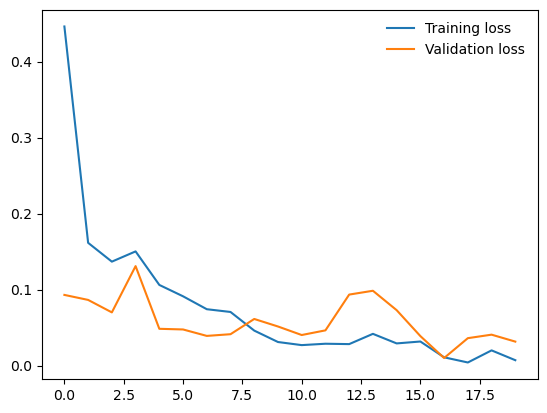

In [9]:
plt.plot(train_graph, label='Training loss')
plt.plot(valid_graph, label='Validation loss')
plt.legend(frameon=False)

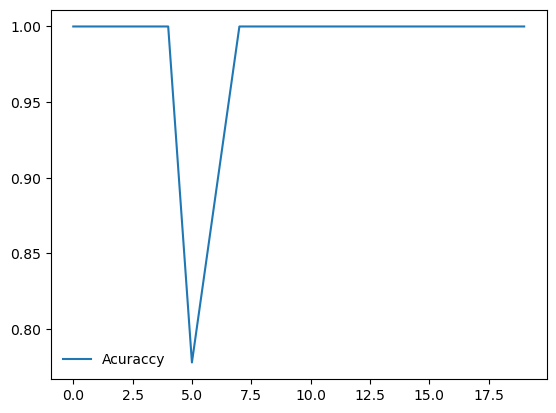

In [10]:
plt.plot(accuracy_graph, label= 'Acuraccy')
plt.legend(frameon=False)

Se evidencia que el entrenamiento se ejecutó de forma correcta. En el mismo sentido, graficamente se observa que el modelo no presenta underfitting ni overfitting. Este se ajusta de forma generalizada frente a los datos escogidos y se logra un accuraccy alto.

#### Cargue del mejor modelo obtenido

Se lee el mejor modelo que se obtuvo en el entrenamiento.

In [11]:
model.load_state_dict(torch.load('Full_model.pt'))
model.cpu()

Net(
  (conv_in): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#### Prueba del modelo obtenido

In [12]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

# Modelo en modo de validación:
model.eval()

# (Función similar adecuada desde la función previa del entrenamiento.)
data, target = next(iter(test_loader))
if train_on_gpu:
    data, target = data.to('cpu'), target.to('cpu')
output = model(data)
loss = criterion(output, target)
test_loss += loss.item()*data.size(0)
_, pred = torch.max(output, 1)    
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
for i in range(len(data)):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# Se muestran algunas métricas:
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy de %5s: N/A' % (classes[i]))

print('\nTest Accuracy (General): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.013920

Test Accuracy de  cars: 100% (193/193)
Test Accuracy de planes: 98% (144/146)

Test Accuracy (General): 99% (337/339)


Se evidencia que para cada una de las categorias a clasificar, con los datos de prueba obtiene un accuraccy adecuado para la cantidad de datos establecida.

#### Visualización de algunas las imágenes de prueba, con su respectiva etiqueta obtenida

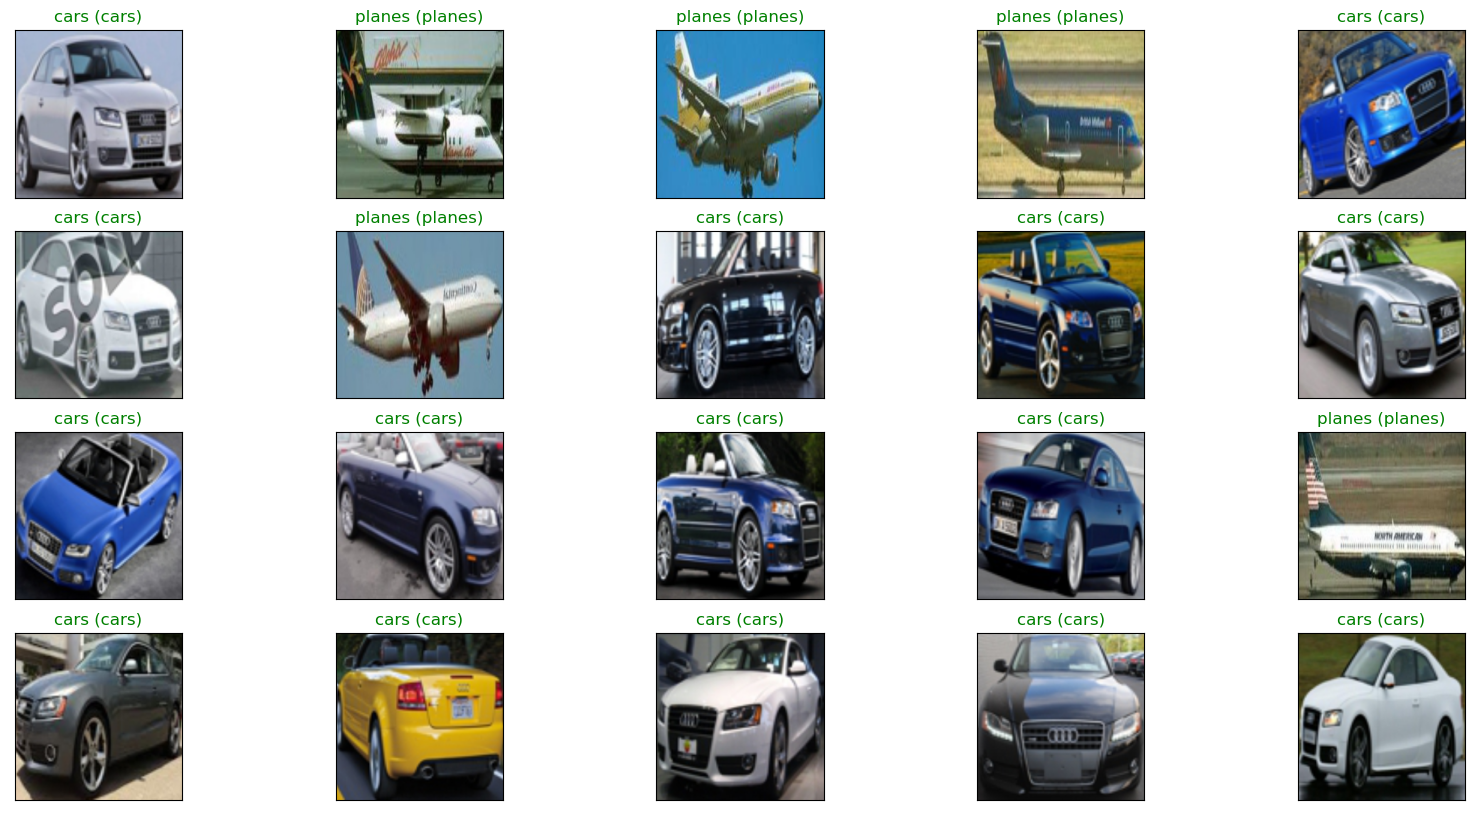

In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.to('cpu')

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize = (20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))

Se observa que para las imágenes mostradas las etiquetas corresponden en su totalidad de forma correcta a su etiqueta original en su gran mayoria.

# _____________________________________________________________________________________________________________________________________

# Clasificación usando Transfer Learning

A continuación, se realiza una solución a la misma aplicación descrita previamente, ejecutando una gran parte de lo realizado hasta el momento, pero utilizando transferencia de aprendizaje para la misma. Se utiliza el modelo preentrenado vgg16_bn y se modifican algunas capas requeridas como las de salida para clasificar las categorias eespecíficas.

Se muestra la arquitectura de la red vgg16_bn.

In [14]:
model = models.vgg16_bn(pretrained = True)
model

c:\Users\GIIEE\Documents\johan\conda\envs\TORCH\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\GIIEE\Documents\johan\conda\envs\TORCH\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Se modifica la última capa correspondiente a la clasificación, para que se ajuste a la aplicación de la clasificación de diferentes tipos de cartas de Naipe.
La nueva arquitectura de la capa de salida se establece de tal forma que la cantidad de neuronas vaya disminuyendo hasta tener como salida la cantidad de medios de transporte a clasificar.

In [15]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(   
                            nn.Linear(25088, 4096),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(4096, 2048),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(2048, 1024),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(1024, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256, 64),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(64, 32),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(32, 16),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(16, 8),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(8, 2)
                    )

Se repiten ahora los procedimientos ejecutados en la sección previa para realizar el entrenamiento y validación del modelo mismo. Como se muestra en las secciones siguientes. Y Finalemnte se hace un análisis respecto a los resultados obtenidos con el diseño entrenado desde cero.

#### Definicón de la función de costo y del optimizador

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Ciclo de entrenamiento

In [17]:
# Número de épocas:
n_epochs = 5

In [18]:
model.cuda()

# Vectores para guardar la variación de la función de pérdida:
train_graph=[]
valid_graph=[]
accuracy_graph = []

for epoch in range(1, n_epochs+1):
    if epoch == 1:
        valid_loss_min = np.Inf # Valor inicial de la función de perdida de validación.

    # Reinicio de las funciones de pérdida:
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    # Entrenamiento #
    #################

    # Modelo en modo entrenamiento:
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        num_correct = 0
        num_total = 0

        # Se mueve el modelo a GPU:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        # Cálculo de los scores:
        output = model(data)

        _, pred = output.max(dim=1) #pred shape (mb_size )
        num_correct += (pred == target.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
        num_total += pred.size(0)

        # Cálculo de la función de pérdida y actualización de parámetros:
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    accuracy_graph.append(float(num_correct)/num_total)
        
    ############## 
    # validación #
    ##############
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Media de la función de pérdida:
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_graph.append(train_loss)
    valid_graph.append(valid_loss) 
        
    # Se muestran las estadísticas:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuraccy: {:.2f} %'.format(
        epoch, train_loss, valid_loss, 100 * (float(num_correct)/num_total)))
    
    # Se guarda el mejor modelo:
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Full_model_transfer.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.503882 	Validation Loss: 0.488329 	Accuraccy: 100.00 %
Validation loss decreased (inf --> 0.488329).  Saving model ...
Epoch: 2 	Training Loss: 0.374634 	Validation Loss: 0.845196 	Accuraccy: 22.22 %
Epoch: 3 	Training Loss: 0.161818 	Validation Loss: 0.153821 	Accuraccy: 100.00 %
Validation loss decreased (0.488329 --> 0.153821).  Saving model ...
Epoch: 4 	Training Loss: 0.129812 	Validation Loss: 0.041933 	Accuraccy: 100.00 %
Validation loss decreased (0.153821 --> 0.041933).  Saving model ...
Epoch: 5 	Training Loss: 0.090034 	Validation Loss: 0.267434 	Accuraccy: 100.00 %


#### Visualización de la variación de la funciones de pérdida para los datos de entrenamiento y validación y del Accuraccy durante el entrenamiento.

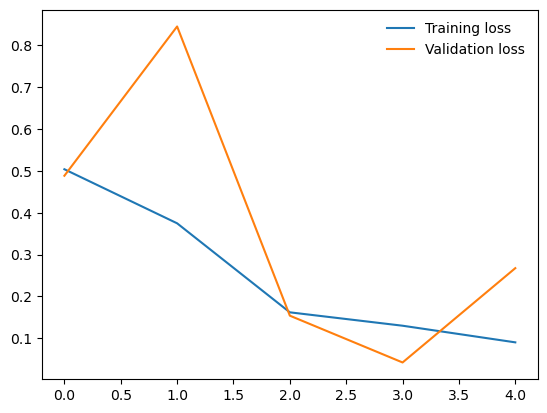

In [19]:
plt.plot(train_graph, label='Training loss')
plt.plot(valid_graph, label='Validation loss')
plt.legend(frameon=False)

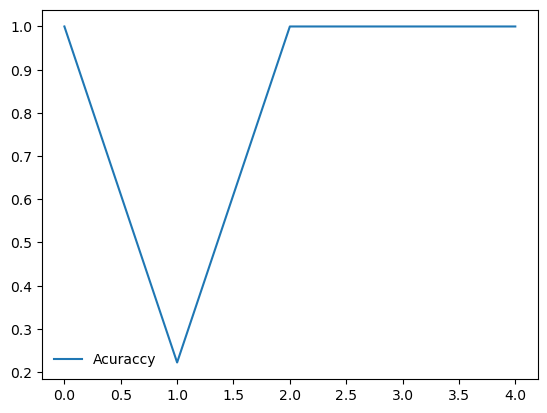

In [20]:
plt.plot(accuracy_graph, label= 'Acuraccy')
plt.legend(frameon=False)

#### Cargue del mejor modelo

In [21]:
model.load_state_dict(torch.load('Full_model_transfer.pt'))
model.cpu()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

#### Prueba del modelo obtenido

In [22]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

# Modelo en modo de validación:
model.eval()

# (Función similar adecuada desde la función previa del entrenamiento.)
data, target = next(iter(test_loader))
if train_on_gpu:
    data, target = data.cpu(), target.cpu()
output = model(data)
loss = criterion(output, target)
test_loss += loss.item()*data.size(0)
_, pred = torch.max(output, 1)    
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
for i in range(len(data)):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# Se muestran algunas métricas:
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy de %5s: N/A' % (classes[i]))

print('\nTest Accuracy (General): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.015305

Test Accuracy de  cars: 100% (193/193)
Test Accuracy de planes: 100% (146/146)

Test Accuracy (General): 100% (339/339)


#### Visualización de algunas las imágenes de prueba, con su respectiva etiqueta obtenida

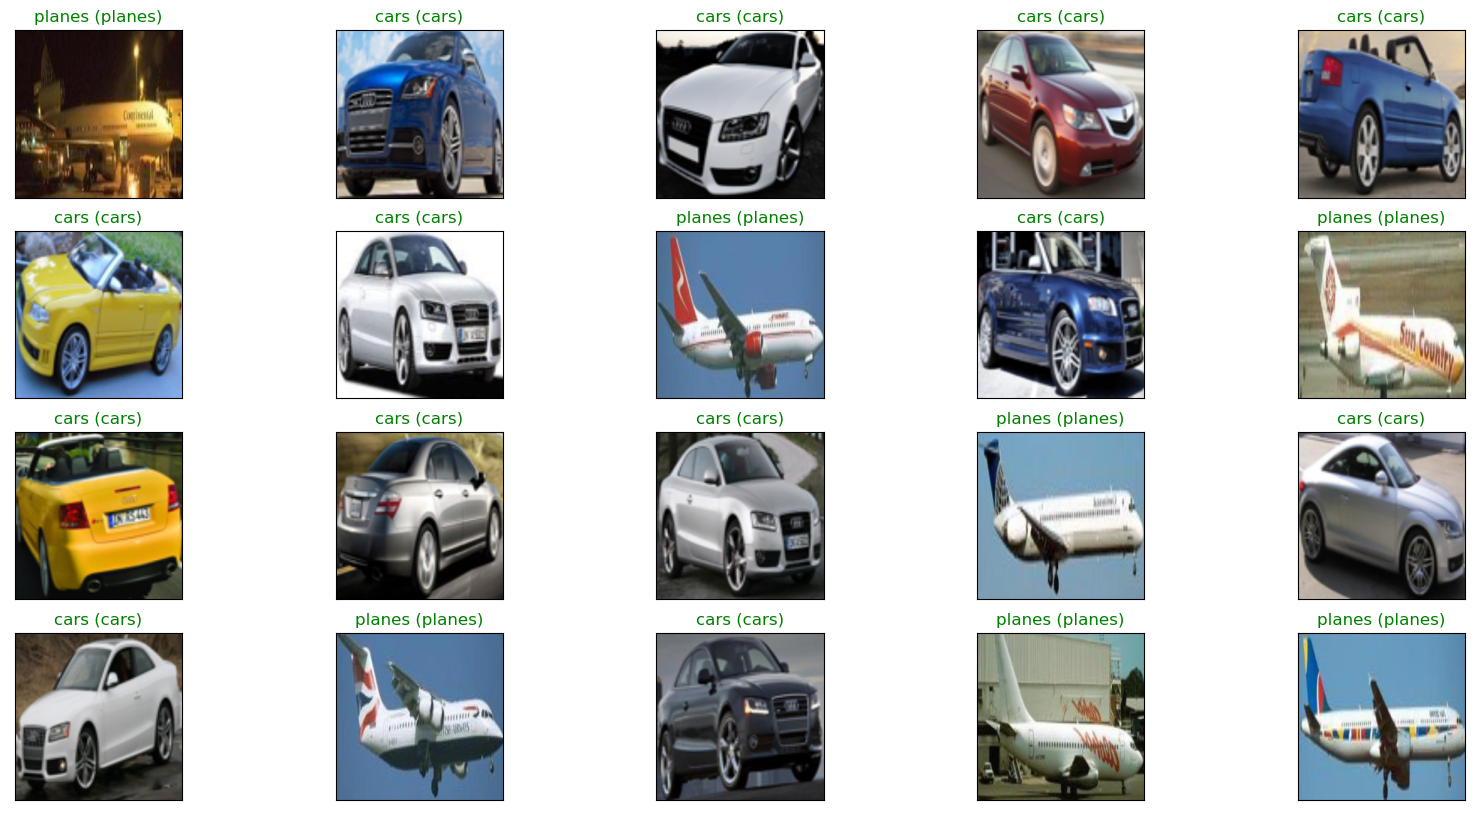

In [23]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cpu()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize = (20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))

Comparando los resultados obtenidos utilizando transferencia de aprendizaje, con los pesos de la red vgg16_bn y de la red entrenada desde cero, se puede determinar que los resultados son muy similares, por lo que permite decir que diseño implementado desde cero es muy adecuado para resolver este caso de clasidicación. En el mismo sentido en la etapa de transferencia de aprendizaje, se realizó el entrenamiento con menos épocas y aún así el modelo responde de forma muy eficiente solo con el entrenamiento de la última capa de clasificación. 

En el mismo sentido, el modelo generaliza de forma correcta, no presenta overfitting ni under fitting. 

Finalmente, se puede concluir que utilizar transferencia de aprendizaje puede agilizar mucho el proceso de entranamiento para una aplicación (como en este caso de clasificación). Lo anterior se puede evidenciar de forma muy leve en elpaso de los dato de prueba por el modelo obtenido, logrando un accuraccy del 99 % utilizando el modelo entrenado desde cero durante 20 épocas, y un accuraccy del 100 % utilizando el modelo con tranferencia de aprendizaje durante 5 épocas solamente. 